# Exploratory Data Analysing Using Youtube Video Data from Oliver Austria Youtube channel

# 1. Aims, objectives and background

## 1.1. Introduction

The popularity and widespread use of online video content have transformed the way people consume media and engage with digital platforms. Among the various online video, YouTube stands out as one of the largest and most influential platforms, attracting billions of users and hosting an enormous amount of video content.

In this data analytics project, I focused on analyzing a specific YouTube channel(__Oliver AUstria: @OliverAustria__) to gain a deeper understanding of its performance, audience engagement, and content strategy. By leveraging the YouTube Data API and employing various data analytics techniques, I am aiming to extract valuable insights that can help channel owners, content creators, and marketers optimize their strategies and make data-driven decisions.

## 1.2. Aims and objectives

The objective of this project is to explore and analyze the following:

- Learn how to access video data and the Youtube API.
- Examine video data to disprove many widely-held "myths" about what makes a video successful on YouTube which includes the following:
     - Does the quantity of likes and comments affect how many people view a video?
     - Does the length of the video affects views and engagement (e.g. likes, comments)?
     - What number of tags do popular videos have? What are the tags that these videos share in common?
     - How frequently do Oliver Austria upload new recordings? On which days in the week?   
- Explore the trending topics on:
     - Which famous subjects are being covered in the videos (e.g. using wordcloud for video titles)?

## 1.3. Steps of the project

1. Obtain video meta data via Youtube API for Oliver Austria channel (this includes several small steps: create a developer key, request data and transform the responses into a usable data format)
1. Prepocess data and engineer additional features for analysis
1. Descriptive Analysis
1. Conclusion

## 1.4. Dataset

### Data selection

I created my own dataset using the __Google Youtube Data API version 3.0__. The exact steps of data creation is presented in section 2. Data Creation below.

### Data limitations

The scope of this project is limited to analyzing a __single YouTube channel__, _specifically for Oliver Austria_. However, the methodologies and techniques employed can be adapted and applied to other channels, allowing stakeholders to gain a comprehensive understanding of their own channels or competitors.

### Ethics of data source

As per __[Youtube API guide](https://developers.google.com/youtube/v3/getting-started)__ , the utilization of YouTube API is for free given that your application send demands inside a share limit. "The  The default share distribution for every application is 10,000 units each day, and you could demand extra quantity by finishing a structure to YouTube API Services on the off chance that you arrive at as far as possible.

Since all data fetched from Youtube API is public data, there is no specific security issues e.g. privacy, taking everything into account. Also, the data acquired is exclusively for research purposes for this case, and not really for any business interests.

# 2. Data creation with Youtube API

1. Created a project on Google Developers Console. 
1. Requested an authorization credential (API key). 
1. Enabled Youtube API for my application, so that I can send API requests to Youtube API services. 
1. Went on Youtube and checked the channel ID of the channel that I would like to include in my research scope.
1. Created the functions for getting the channel statistics via the API.

In [7]:
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Google API
from googleapiclient.discovery import build

In [8]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Angelica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Angelica\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
api_key = 'XXX'

In [56]:
channel_ids = ['UCHHYB05slIGQR5NT92EPr5g',
               # more channels here
              ]

In [57]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

### Get channel statistics

Using the get_channel_stats function defined below, now we are going to obtain the channel statistics for my scope.

In [58]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

In [59]:
channel_stats = get_channel_stats(youtube, channel_ids)

Now, I can print out the data and take a look at the channel statistics overview.

In [74]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Oliver Austria,2470000,124430762,186,UUHHYB05slIGQR5NT92EPr5g


The YouTube channel of Oliver Austria has _2,470,000 subscribers_ and _186 videos uploaded_, as seen above.

### Get video statistics

In the next step, I will obtain the video statistics for the channels. In total, I obtained 186 videos as seen below.

In [75]:
playlist_id = "UUHHYB05slIGQR5NT92EPr5g"

In [76]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [77]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [78]:
len(video_ids)

186

In [79]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [81]:
# Get video details
video_df = get_video_details(youtube, video_ids)

In [82]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,C-J2Bl-a2Mo,Oliver Austria,Pinoy Architect Reacts to House and Lot in Tarlac,Bisitahin natin ang Camella Tarlac mah dudes u...,[Pinoy Architect Reacts to House and Lot in Ta...,2023-05-05T11:47:10Z,87683,1551,None,123,PT15M51S,hd,false
1,E7VYpfBQ3xw,Oliver Austria,Cooling Your House For Free,"Dahil summer sa Pilipinas all year round, pagu...","[Cooling Your House For Free, paano palamigin ...",2023-04-28T11:55:43Z,199973,4544,None,176,PT10M4S,hd,false
2,PBlKUrv_EdU,Oliver Austria,Gusto mo Magpakabit ng Dropped Ceiling??,"Balak mo ba magpakabit ng ceiling, pero hindi ...","[Gusto mo Magpakabit ng Dropped Ceiling??, cei...",2023-04-21T11:45:32Z,125215,3718,None,117,PT7M45S,hd,false
3,FVWg4txWtrk,Oliver Austria,Pinoy Architect Reacts to Alice Eduardo House ...,Tara at samahan natin si Karen Davila sa pagbi...,[Pinoy Architect Reacts to Alice Eduardo House...,2023-03-24T11:59:47Z,450266,7687,None,362,PT11M10S,hd,false
4,ltGiUMMxxaU,Oliver Austria,Pinoy Architect Looks for a Condo with Green S...,At ayun pumasyal nanaman tayo sa Manila mah du...,[Pinoy Architect Looks for a Condo with Green ...,2023-03-10T12:00:03Z,67032,1289,None,78,PT15M47S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,azUxbnvX3NQ,Oliver Austria,Magic Doraemon Toy Unboxing,Yo mga dude!! Ngayong araw i-uunbox natin ang ...,"[Magic Doraemon Toy Unboxing, magic, doreamon,...",2020-07-10T11:50:08Z,71157,3604,None,344,PT5M30S,hd,false
182,F7iviFMihNg,Oliver Austria,One Piece TONY CHOPPER Plastic Model Kit Unbox...,Yo mga dudes!! Long time no upload! Anyways ng...,[One Piece TONY CHOPPER Plastic Model Kit Unbo...,2020-04-25T12:10:53Z,49888,2435,None,237,PT6M20S,hd,false
183,_fFh8BoJL6k,Oliver Austria,Best MOBILE LEGENDS and PUBG GAME HANDLES Unde...,Lets check out some super cheap game handles n...,[MOBILE LEGENDS at PUBG GAME HANDLES Under 100...,2019-11-08T11:00:29Z,96323,2785,None,134,PT5M10S,hd,false
184,nQkZvfdkDzc,Oliver Austria,Teeny Weeny Joker Sculpture,Sino nakapanuod nung joker 2019? Imba mah dude...,"[Joker, Teeny Weeny Joker Sculpture, joker 201...",2019-10-25T10:12:40Z,31055,1663,None,119,PT5M59S,hd,false


# Data pre-processing

To be able to make use of the data for analysis, I need to perform a data cleansing. Firstly, I would like reformat some columns, especially the date and time columns such as "pushlishedAt" and "duration". 

### Check for empty values

In [83]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [84]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

### Enriching data

I want to enhance the data for further analyses. This includes:
-  create published date column with another column showing the day in the week the video was published, which will be useful for later analysis.
-  convert video duration to seconds instead of the current default string format
-  calculate number of tags for each video
-  calculate comments and likes per 1000 view ratio
-  calculate title character length

In [85]:
# Convert count columns to numeric columns
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [86]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [102]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [103]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [104]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,951.0,PT15M51S
1,604.0,PT10M4S
2,465.0,PT7M45S
3,670.0,PT11M10S
4,947.0,PT15M47S
...,...,...
181,330.0,PT5M30S
182,380.0,PT6M20S
183,310.0,PT5M10S
184,359.0,PT5M59S


In [105]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount,title_no_stopwords,tagsCount
0,C-J2Bl-a2Mo,Oliver Austria,Pinoy Architect Reacts to House and Lot in Tarlac,Bisitahin natin ang Camella Tarlac mah dudes u...,[Pinoy Architect Reacts to House and Lot in Ta...,2023-05-05 11:47:10+00:00,87683.0,1551.0,NaN,123.0,PT15M51S,hd,false,Friday,951.0,9,"[Pinoy, Architect, Reacts, House, Lot, Tarlac]",9
1,E7VYpfBQ3xw,Oliver Austria,Cooling Your House For Free,"Dahil summer sa Pilipinas all year round, pagu...","[Cooling Your House For Free, paano palamigin ...",2023-04-28 11:55:43+00:00,199973.0,4544.0,NaN,176.0,PT10M4S,hd,false,Friday,604.0,10,"[Cooling, Your, House, For, Free]",10
2,PBlKUrv_EdU,Oliver Austria,Gusto mo Magpakabit ng Dropped Ceiling??,"Balak mo ba magpakabit ng ceiling, pero hindi ...","[Gusto mo Magpakabit ng Dropped Ceiling??, cei...",2023-04-21 11:45:32+00:00,125215.0,3718.0,NaN,117.0,PT7M45S,hd,false,Friday,465.0,10,"[Gusto, mo, Magpakabit, ng, Dropped, Ceiling??]",10
3,FVWg4txWtrk,Oliver Austria,Pinoy Architect Reacts to Alice Eduardo House ...,Tara at samahan natin si Karen Davila sa pagbi...,[Pinoy Architect Reacts to Alice Eduardo House...,2023-03-24 11:59:47+00:00,450266.0,7687.0,NaN,362.0,PT11M10S,hd,false,Friday,670.0,10,"[Pinoy, Architect, Reacts, Alice, Eduardo, Hou...",10
4,ltGiUMMxxaU,Oliver Austria,Pinoy Architect Looks for a Condo with Green S...,At ayun pumasyal nanaman tayo sa Manila mah du...,[Pinoy Architect Looks for a Condo with Green ...,2023-03-10 12:00:03+00:00,67032.0,1289.0,NaN,78.0,PT15M47S,hd,false,Friday,947.0,10,"[Pinoy, Architect, Looks, Condo, Green, Spaces]",10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,azUxbnvX3NQ,Oliver Austria,Magic Doraemon Toy Unboxing,Yo mga dude!! Ngayong araw i-uunbox natin ang ...,"[Magic Doraemon Toy Unboxing, magic, doreamon,...",2020-07-10 11:50:08+00:00,71157.0,3604.0,NaN,344.0,PT5M30S,hd,false,Friday,330.0,16,"[Magic, Doraemon, Toy, Unboxing]",16
182,F7iviFMihNg,Oliver Austria,One Piece TONY CHOPPER Plastic Model Kit Unbox...,Yo mga dudes!! Long time no upload! Anyways ng...,[One Piece TONY CHOPPER Plastic Model Kit Unbo...,2020-04-25 12:10:53+00:00,49888.0,2435.0,NaN,237.0,PT6M20S,hd,false,Saturday,380.0,7,"[One, Piece, TONY, CHOPPER, Plastic, Model, Ki...",7
183,_fFh8BoJL6k,Oliver Austria,Best MOBILE LEGENDS and PUBG GAME HANDLES Unde...,Lets check out some super cheap game handles n...,[MOBILE LEGENDS at PUBG GAME HANDLES Under 100...,2019-11-08 11:00:29+00:00,96323.0,2785.0,NaN,134.0,PT5M10S,hd,false,Friday,310.0,8,"[Best, MOBILE, LEGENDS, PUBG, GAME, HANDLES, U...",8
184,nQkZvfdkDzc,Oliver Austria,Teeny Weeny Joker Sculpture,Sino nakapanuod nung joker 2019? Imba mah dude...,"[Joker, Teeny Weeny Joker Sculpture, joker 201...",2019-10-25 10:12:40+00:00,31055.0,1663.0,NaN,119.0,PT5M59S,hd,false,Friday,359.0,8,"[Teeny, Weeny, Joker, Sculpture]",8


# Descriptive Analysis

### What are the best performing videos of Oliver Austria?

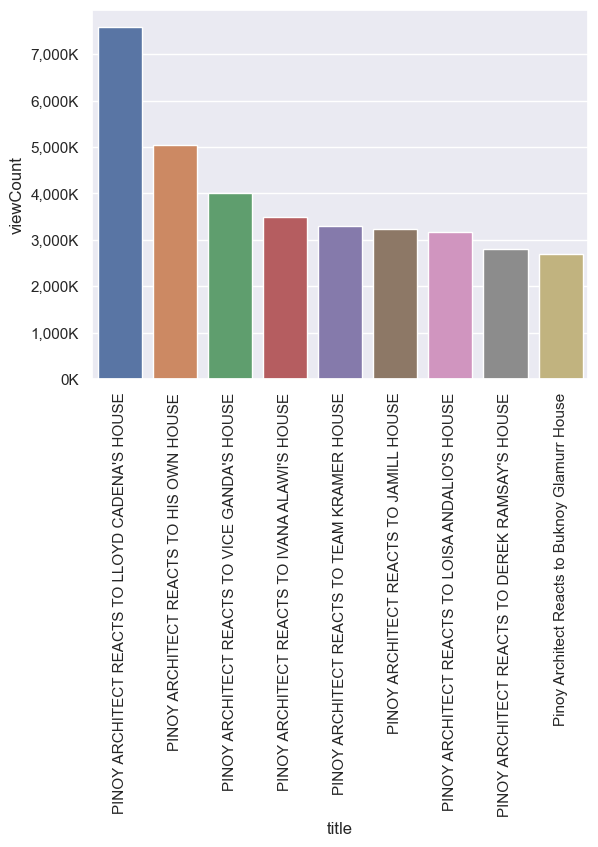

In [106]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

The data shows that the video entitled __Pinoy Architect Reacts to Lloyd Cadena's House__ earned _most views_ among Oliver Austria's videos.

### What are the least performing videos of Oliver Austria?

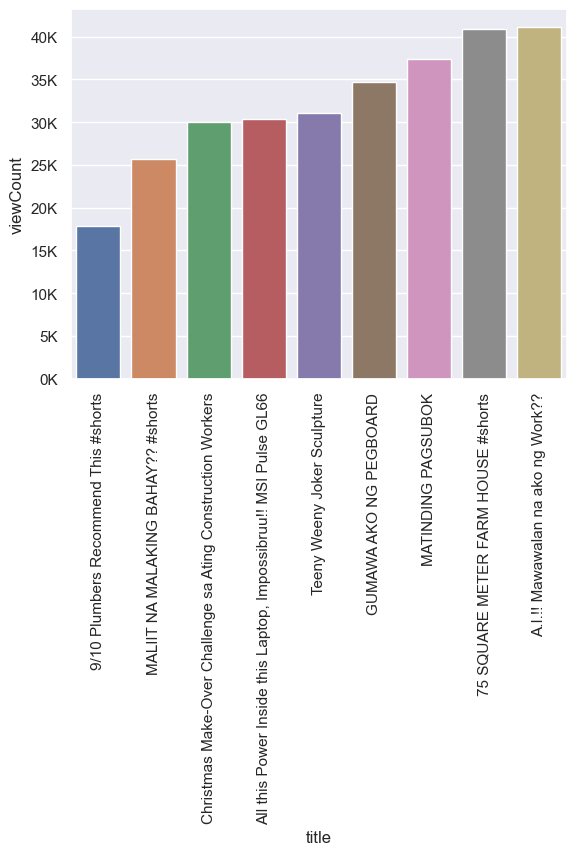

In [107]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

The data shows that the video entitled Pinoy _9/10 Plumbers Recommend This #short_ earned the _least views_ among Oliver Austria's videos.

### Does the quantity of likes and comments affect how many people view a video?

I would like to check if comments and likes do correlate with how many views a video would get. 

<Axes: xlabel='likeCount', ylabel='viewCount'>

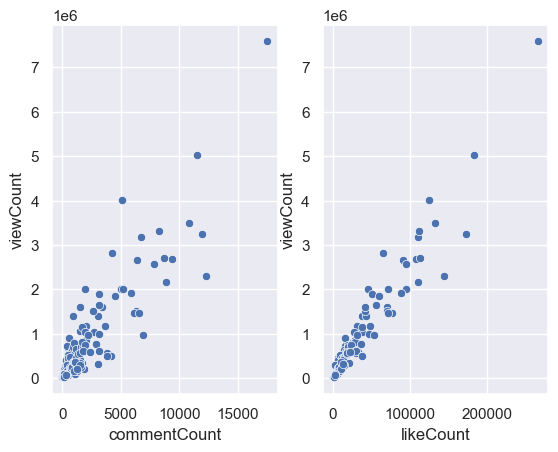

In [108]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

In the plots above, it can be observed that the number of views and number of comments/ likes strongly correlated with each other. The more people watching a video, the more likely this video will get comments and likes. 

### Does the length of the video affects views and engagement (e.g. likes, comments)?

<Axes: xlabel='durationSecs', ylabel='Count'>

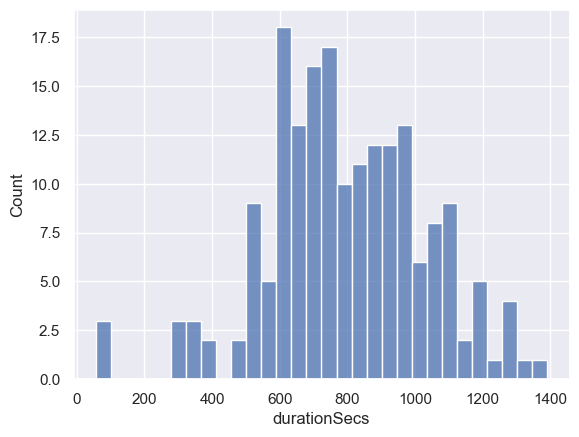

In [93]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

As can be seen in the histogram above, __most of the videos__ in Oliver Austria's channel are between _600 to 700 seconds, which is about 10 to 11 minutes_.

Now, I plot the duration against comment count and like count. 

<Axes: xlabel='durationSecs', ylabel='likeCount'>

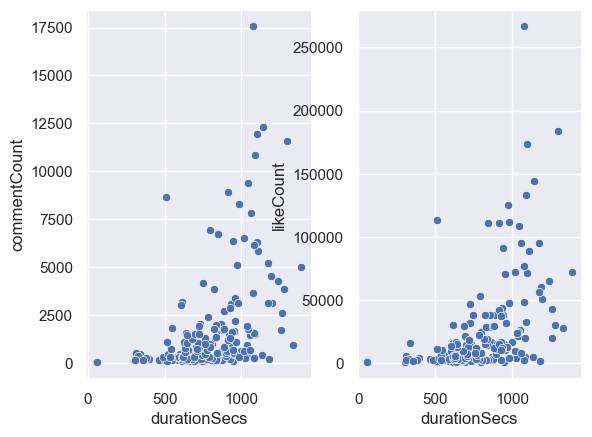

In [94]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

It can be seen that actually shorter videos tend to get more likes and comments than very long videos. Also, Oliver Austria's videos tends to __receive likes and comments__ _mostly starting on 500th to 1,000th seconds(8 to 16 minutes)_.

### Wordcloud for words in title

As I'm interested to see what Oliver Austria is making videos about, and which terms most frequently appear in his video titles, I will create a wordcloud for the most common words. I need to remove the stopwords such as "you", "I", "the", etc. which do note contribute a lot to the meaning of the title.

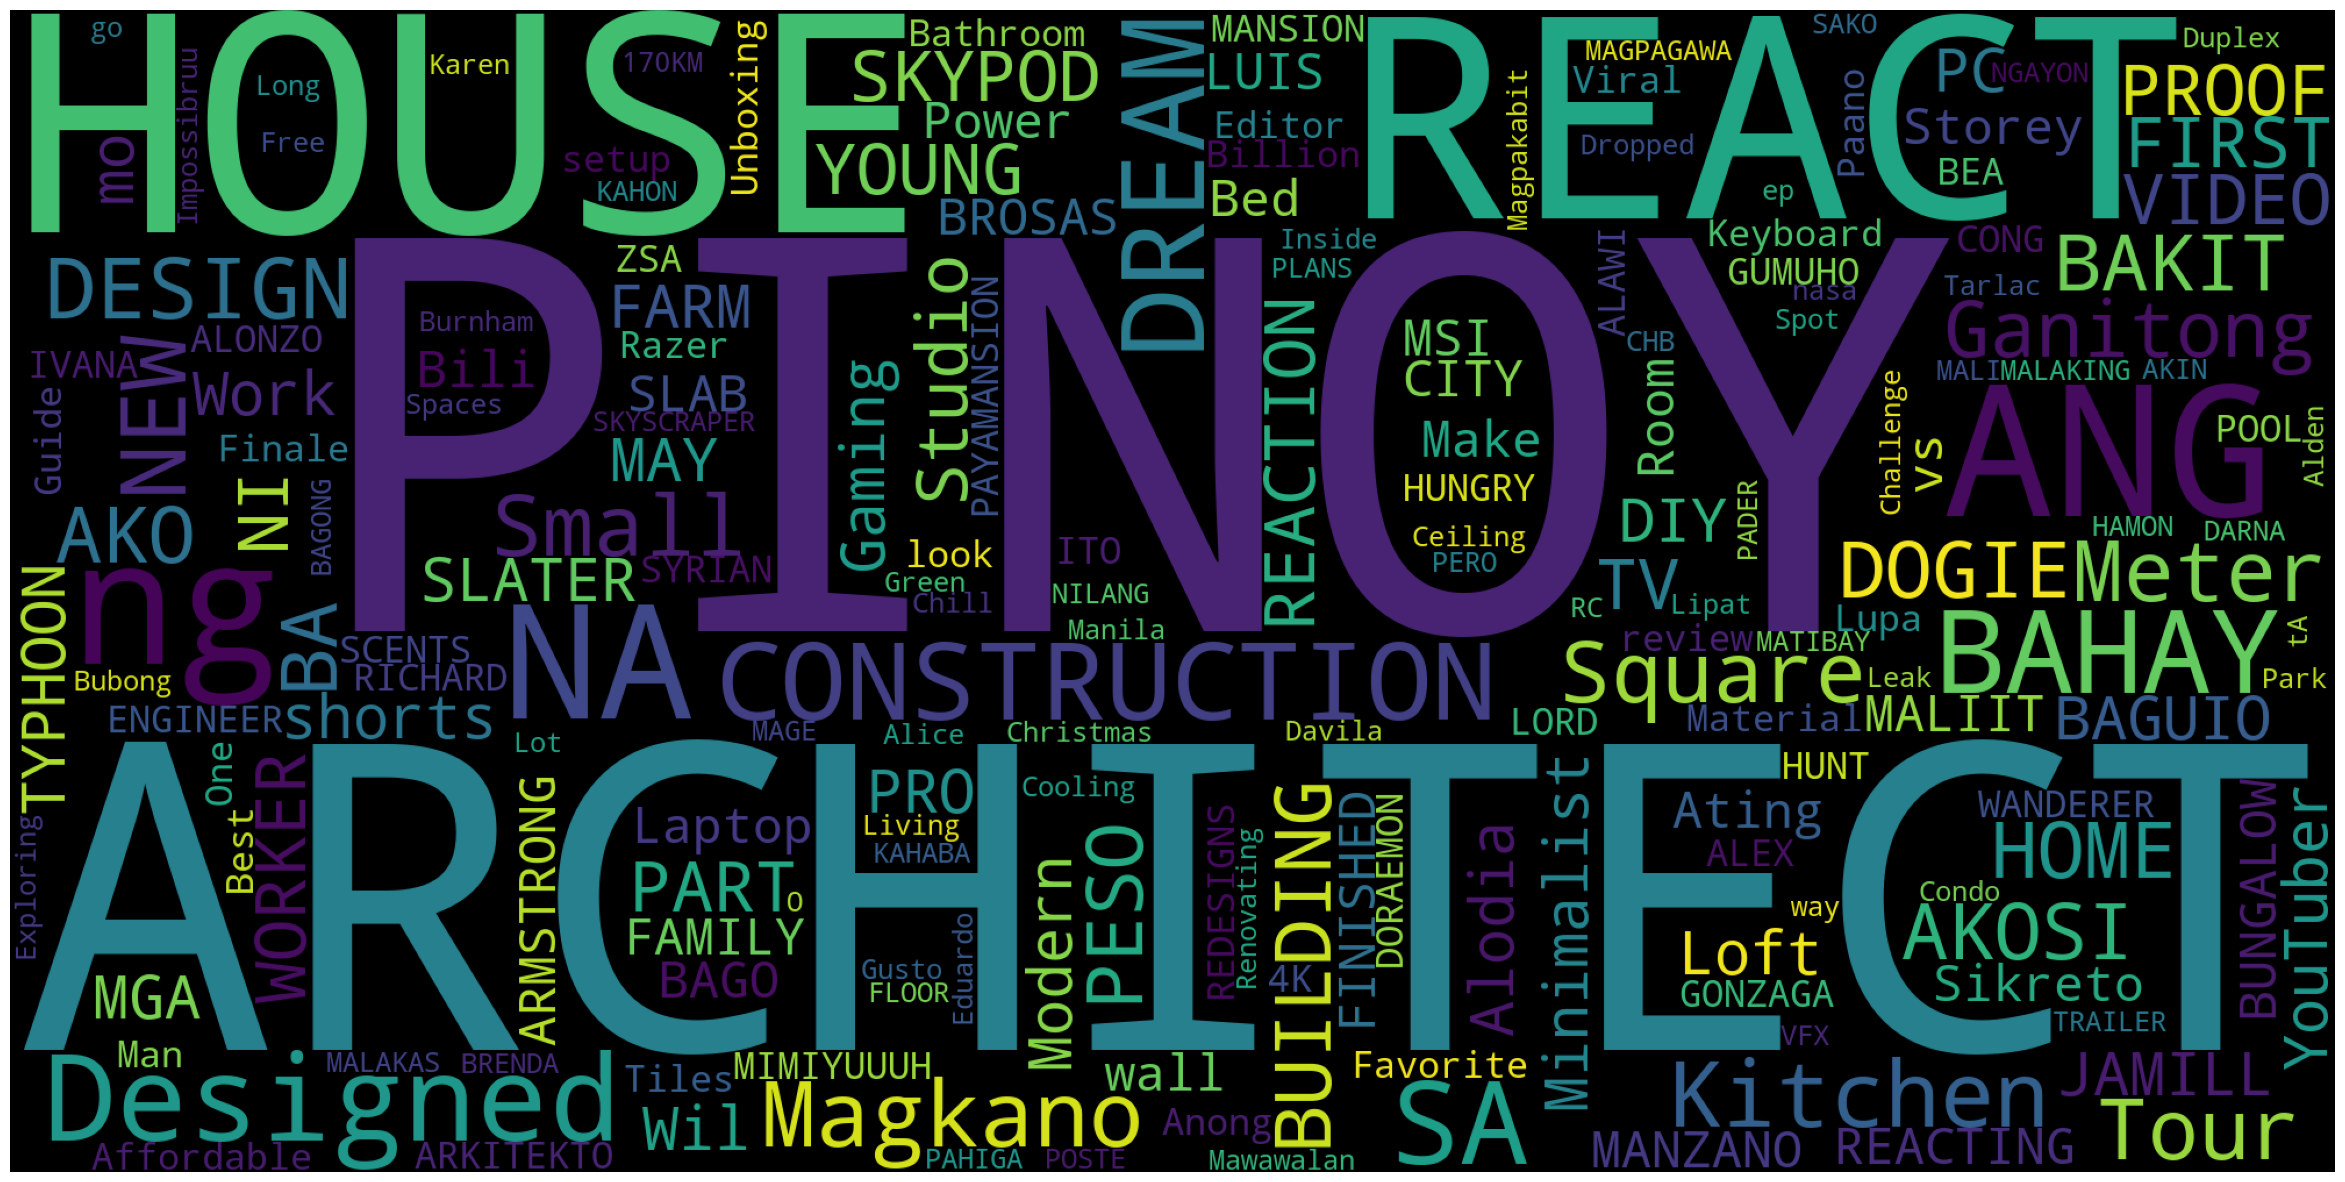

In [100]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

It can be seen that __most common__ words are _pinoy, house, react, architect_, which is very expected.

### Number of tags vs views

It seems that most videos have between 11 and 25 tags. The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views.

<Axes: xlabel='tagsCount', ylabel='viewCount'>

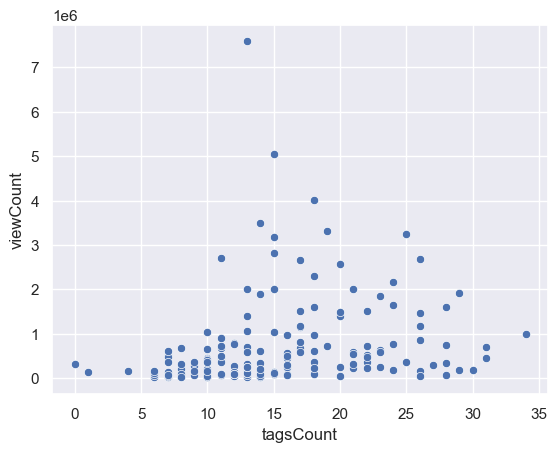

In [109]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

### How frequently do Oliver Austria upload new recordings? On which days in the week?

It's interesting to see that _most videos are uploaded on Fridays_. This could be because of the nature of the niche that is more geared towards tutorials and heavy materials, which is not suitable for weekends' consumption. But it could also just means that Oliver Austria work on his videos during the weekend or during the week and upload them on Friday.

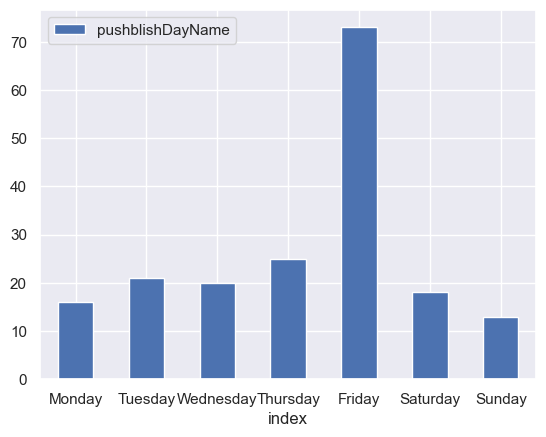

In [111]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

## Conclusion

In this project, I have explored the video data of Oliver Austria YouTube channel and revealed many interesting findings such as:
- The more likes and comments a video has, the more views the video gets (it is not guaranteed that this is a causal relationship, it is simply a correlation and can work both way). Likes seem to be a better indicator for interaction than comments and the number of likes seem to follow the "social proof", which means the more views the video has, the more people will like it.
- Most of his videos are between 10 and 11 minutes.
- Most of the videos have between 11 and 25 tags.
- Videos are usually uploaded on Fridays.
- Terms most frequently appear in his video titles are:
     - house
     - reach
     - pinoy
     - architect

__Project limitation:__
The findings should also be taken with a grain of salt for a number of reasons:
 - The number of videos is quite small (the dataset has only ~186 videos as of writing (2023-06-03))
 - There are numerous different variables that haven't been taken into the analysis, including the marketing strategy and numerous irregular impacts that would influence how fruitful a video is.

## References/ Resources used:

 1. __[Youtube API]( https://developers.google.com/youtube/v3)__ 
 1. __[Youtube API for Python: How to Create a Unique Data Portfolio Project](https://youtu.be/D56_Cx36oGY)__
 1. __[Converting video durations to time function](https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3)__
 1. __[Markdown for Jupyter notebooks cheatsheet](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet)__
  1. __[Get a channel ID from YouTube?](https://stackoverflow.com/questions/14366648/how-can-i-get-a-channel-id-from-youtube)__